In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyts.image import GramianAngularField

import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import Callback
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import entropy
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from tensorflow.keras.models import save_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid


import cv2 # Import OpenCV
from tqdm import tqdm


seed = 42
random.seed(seed)
from sklearn.utils import check_random_state
check_random_state(seed)

np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)


# Data

In [78]:
meter_data_dir = "../preprocessing/data/meter_data/48190963_Loads_hourly.csv"
conditioning_data_dir = "../preprocessing/data/conditioning_data/48190936_Weather.csv"

meter_data = pd.read_csv(meter_data_dir)
meter_data = meter_data[["NET", "Cooling", "PV_meter1_load (kW)", "PV_meter2_load (kW)", "Battery cabinet", "Sumppump", "Plug_Basement", "Solar rapid shutdown"]] #subset for dev
#meter_data = meter_data[["NET", "Cooling", "PV_meter1_load (kW)", "Battery cabinet"]] #subset for dev
print(meter_data.shape)
meter_data.head()


(8760, 8)


,NET,Cooling,PV_meter1_load (kW),PV_meter2_load (kW),Battery cabinet,Sumppump,Plug_Basement,Solar rapid shutdown
0,1.422260,0.002001,-0.050127,-0.048380,0.003126,0.001130,0.190117,0.003929
1,1.438863,0.002010,-0.049362,-0.050536,0.003116,0.001148,0.198712,0.004033
2,1.401933,0.001990,-0.048622,-0.047862,0.003119,0.001133,0.163461,0.004018
3,1.410452,0.002003,-0.048963,-0.050321,0.003120,0.001137,0.173353,0.003993
4,1.426215,0.001997,-0.048785,-0.049283,0.003112,0.001126,0.197125,0.003896


In [79]:
conditioning_data = pd.read_csv(conditioning_data_dir, encoding='unicode_escape')
conditioning_data = conditioning_data.iloc[:, 1:]
print(conditioning_data.shape)
conditioning_data.head()

(8760, 8)


,"Air temperature (gund, ¡É)","Relative humidity (gund, %)","Wind speed (gund, m/s)","Weather data, Wind speed (m/s)","Wind direction (gund, ¡Æ)","Weather data, Wind direction","Weather data, Rain","Solar radiation (gund, W/m^2)"
0,12.576667,88.250000,0.208333,0.033333,98.583333,129.857023,0,1.0
1,12.975833,89.908333,0.000000,0.033333,111.083333,129.857023,0,1.0
2,13.330833,90.491667,0.000000,0.033333,98.333333,129.857023,0,1.0
3,13.648333,87.258333,0.250000,0.050000,84.166667,109.500000,0,1.0
4,13.836667,80.758333,0.166667,0.050000,85.833333,119.250157,0,1.0


In [80]:
multi_var_ts = np.asarray(meter_data)
gaf = GramianAngularField(image_size=multi_var_ts.shape[1], method='summation')
gaf_images = [gaf.fit_transform(ts.reshape(1, -1))[0] for ts in multi_var_ts]
ts_images = np.asarray(gaf_images)
ts_images.shape

(8760, 8, 8)

U-net with n-downsampling layers, input needs to be divisible by 2^n<br>
i.e. 4 downsampling layers = 2^4 = 16x16 img shape

In [81]:
img_rows = ts_images.shape[1]
img_cols = ts_images.shape[2]
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [82]:
img_shape

(8, 8, 1)

In [83]:
X_train = np.tile(ts_images, (1, 1, 1, channels))
X_train = np.transpose(X_train, (1, 0, 2, 3))
X_train.shape

(8760, 1, 8, 8)

In [84]:
y_train = np.asarray(conditioning_data)
dims_meta = y_train.shape[1]
y_train.shape

(8760, 8)

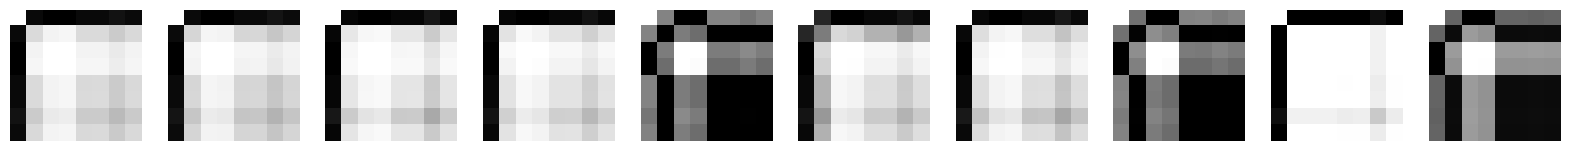

In [85]:
import random
# Generate 10 unique random indices
random_indices = random.sample(range(X_train.shape[0]), 10)

# Extract the randomly selected images
random_images = X_train[random_indices]

# Now random_images has shape [10, 1, 64, 64]
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for idx, ax in enumerate(axes):
    ax.imshow(random_images[idx].squeeze(), cmap='gray') # squeeze to remove the channel dimension
    ax.axis('off') # to remove the axes for clarity

plt.show()

# Model

In [86]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels
        

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        
        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        
        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)
        
        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x

    
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        
        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]
        
        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim
        
        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        
        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)
    
def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t,s] = unorm(store[t,s])
    return nstore

def norm_torch(x_all):
    # runs unity norm on all timesteps of all samples
    # input is (n_samples, 3,h,w), the torch image format
    x = x_all.cpu().numpy()
    xmax = x.max((2,3))
    xmin = x.min((2,3))
    xmax = np.expand_dims(xmax,(2,3)) 
    xmin = np.expand_dims(xmin,(2,3))
    nstore = (x - xmin)/(xmax - xmin)
    return torch.from_numpy(nstore)

def gen_tst_context(n_cfeat):
    """
    Generate test context vectors
    """
    vec = torch.tensor([
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0]]      # human, non-human, food, spell, side-facing
    )
    return len(vec), vec

def plot_grid(x,n_sample,n_rows,save_dir,w):
    # x:(n_sample, 3, h, w)
    ncols = n_sample//n_rows
    grid = make_grid(norm_torch(x), nrow=ncols)  # curiously, nrow is number of columns.. or number of items in the row.
    save_image(grid, save_dir + f"run_image_w{w}.png")
    print('saved image at ' + save_dir + f"run_image_w{w}.png")
    return grid

def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False):
    ncols = n_sample//nrows
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                               # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow
    
    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i,(row*ncols)+col]))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0]) 
    plt.close()
    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani

In [87]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=64):  # cfeat - context features
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height

        self.init_conv = ResidualConvBlock(in_channels, n_feat)

        # Only two down-sampling layers
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 4 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d((self.h//8)), nn.GELU())

        self.timeembed1 = EmbedFC(1, 4 * n_feat)
        self.timeembed2 = EmbedFC(1, 2 * n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 4 * n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 2 * n_feat)

        # Only two up-sampling layers
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, self.h//8, self.h//8),
            nn.GroupNorm(8, 4 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(8 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(3 * n_feat, n_feat)

        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        #print(f"input shape: {x.shape}")
        x = self.init_conv(x)
        #print(f"init conv shape: {x.shape}")
        down1 = self.down1(x)
        #print(f"down1 shape: {down1.shape}")
        down2 = self.down2(down1)
        #print(f"down2 shape: {down2.shape}")
        hiddenvec = self.to_vec(down2)
        #print(f"hiddenvec shape: {hiddenvec.shape}")
        
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x.device)

        #TODO if c is not none pas through embedding
        
        # Embeddings
        cemb1 = self.contextembed1(c).view(x.shape[0], self.n_feat * 4, 1, 1)
        #print(f"cemb1 shape: {cemb1.shape}")
        temb1 = self.timeembed1(t).view(x.shape[0], self.n_feat * 4, 1, 1)
        #print(f"temb1 shape: {temb1.shape}")
        cemb2 = self.contextembed2(c).view(x.shape[0], self.n_feat * 2, 1, 1)
        #print(f"cemb2 shape: {cemb2.shape}")
        temb2 = self.timeembed2(t).view(x.shape[0], self.n_feat * 2, 1, 1)
        #print(f"temb2 shape: {temb2.shape}")

        # Upsampling
        up1 = self.up0(hiddenvec)
        #print(f"up1 shape: {up1.shape}")
        up2 = self.up1(cemb1 * up1 + temb1, down2)
        #print(f"up2 shape: {up2.shape}")
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        #print(f"up3 shape: {up3.shape}")
        out = self.out(torch.cat((up3, x), 1))

        return out

## Validation

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = y_train.shape[1]
height = img_cols# 16x16 image
print(f"height: {height}")

x_tensor = torch.from_numpy(X_train)
dataset = TensorDataset(x_tensor)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=5)
sample = next(iter(dataloader))[0]
sample = sample.to(device)

t = torch.randint(1, 500 + 1, (sample.shape[0],)).to(device)

nn_model = ContextUnet(in_channels=channels, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
out = nn_model(sample.float(), t.float())

height: 8


# DDPM

In [89]:
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = int(y_train.shape[1]) # context vector is of size 7
height = img_cols # 16x16 image

# training hyperparameters
batch_size = 10 #100
n_epoch = 5
lrate=1e-3

In [90]:
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

In [91]:
import torch
from torch.utils.data import TensorDataset

x_tensor = torch.from_numpy(X_train)
y_tensor = torch.from_numpy(y_train)
print(y_tensor.shape)

# Create a TensorDataset from the tensors
dataset = TensorDataset(x_tensor, y_tensor)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

torch.Size([8760, 8])


In [92]:
nn_model = ContextUnet(in_channels=channels, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# re setup optimizer
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [93]:
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [94]:
def show_images(imgs, nrow=2):
  _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
  axs = axs.flatten()

  if imgs.shape[1]==1:
    imgs = imgs.repeat(1, 3, 1, 1)

  for img, ax in zip(imgs, axs):
      img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(img)
  plt.show()

In [95]:
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, channels, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [96]:
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [97]:
def r_squared(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def rmse(a, b):
    return torch.sqrt(torch.mean((a - b) ** 2))

In [98]:
nn_model.train()

list_fid_score = []
list_rmse_score = []

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader, mininterval=2 )
    epoch_loss = 0.0   # initialize epoch loss
    n_batches = 0      # count number of batches
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)
        
        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        noise = noise.type(torch.float32)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)

        # use network to recover noise
        time = t / timesteps
        time = time.type(torch.float32)
        x_pert = x_pert.type(torch.float32)
        c = c.type(torch.float32)
        
        pred_noise = nn_model(x_pert, time, c=c)
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        epoch_loss += loss.item()
        n_batches += 1
        loss.backward()

        optim.step()

epoch 0


100%|██████████| 876/876 [00:12<00:00, 71.28it/s]


epoch 1


100%|██████████| 876/876 [00:11<00:00, 73.62it/s]


epoch 2


100%|██████████| 876/876 [00:11<00:00, 75.37it/s]


epoch 3


100%|██████████| 876/876 [00:11<00:00, 76.72it/s]


epoch 4


100%|██████████| 876/876 [00:11<00:00, 75.56it/s]


# Sampling
## No Conditioning

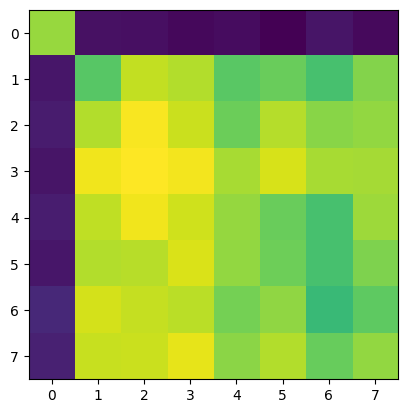

In [99]:
gen_img, _ = sample_ddpm_context(1, None)
gen_img = gen_img.cpu().numpy()
gen_img = np.transpose(gen_img, (0, 2, 3, 1))
gen_img = gen_img.squeeze(-1)
plt.imshow(gen_img.squeeze())

## Conditioning

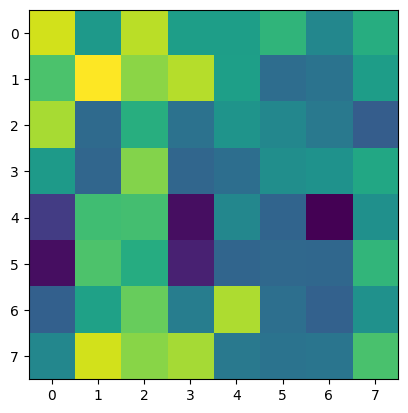

In [100]:
cond = torch.tensor(y_train[0]).float().to(device)
gen_img, _ = sample_ddpm_context(1, cond)
gen_img = gen_img.cpu().numpy()
gen_img = np.transpose(gen_img, (0, 2, 3, 1))
gen_img = gen_img.squeeze(-1)
plt.imshow(gen_img.squeeze())